<a href="https://colab.research.google.com/github/Cain2299/Factory-Parts-Classifier-Grad-CAM/blob/main/projeto%201/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from tqdm import tqdm
from PIL import Image
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

Usando device: cpu


# Criando Pastas


In [4]:
import os

# Define os caminhos das pastas
train_dir_path = 'data/train'
val_dir_path = 'data/val'

# Cria as pastas se não existirem
os.makedirs(train_dir_path, exist_ok=True)
os.makedirs(val_dir_path, exist_ok=True)

print(f"Pasta '{train_dir_path}' criada com sucesso (ou já existia).")
print(f"Pasta '{val_dir_path}' criada com sucesso (ou já existia).")

Pasta 'data/train' criada com sucesso (ou já existia).
Pasta 'data/val' criada com sucesso (ou já existia).


In [5]:
import os

if os.path.exists('data'):
    print("A pasta 'data' existe.")
else:
    print("A pasta 'data' NÃO existe.")

A pasta 'data' existe.


# Carregando imagens

In [6]:
import os
import shutil

source_train_class_A = '/content/drive/MyDrive/projetos GITHUB/projeto 1/data/train/ok'
dest_train_class_A = 'data/train/classe_A'

os.makedirs(dest_train_class_A, exist_ok=True)
for filename in os.listdir(source_train_class_A):
    shutil.copy(os.path.join(source_train_class_A, filename), dest_train_class_A)

In [7]:
source_train_class_A = '/content/drive/MyDrive/projetos GITHUB/projeto 1/data/train/defeito'
dest_train_class_A = 'data/train/classe_B'

os.makedirs(dest_train_class_A, exist_ok=True)
for filename in os.listdir(source_train_class_A):
    shutil.copy(os.path.join(source_train_class_A, filename), dest_train_class_A)

In [8]:
source_train_class_A = '/content/drive/MyDrive/projetos GITHUB/projeto 1/data/val/ok'
dest_train_class_A = 'data/val/classe_A'

os.makedirs(dest_train_class_A, exist_ok=True)
for filename in os.listdir(source_train_class_A):
    shutil.copy(os.path.join(source_train_class_A, filename), dest_train_class_A)

In [9]:
source_train_class_A = '/content/drive/MyDrive/projetos GITHUB/projeto 1/data/val/defeito'
dest_train_class_A = 'data/val/classe_B'

os.makedirs(dest_train_class_A, exist_ok=True)
for filename in os.listdir(source_train_class_A):
    shutil.copy(os.path.join(source_train_class_A, filename), dest_train_class_A)

# Dataset de peças

In [10]:
data_dir = "data"  # raiz do dataset

train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "val")

image_size = 224

train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # stats do ImageNet
        std=[0.229, 0.224, 0.225]
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir,   transform=val_transform)

class_names = train_dataset.classes  # ex.: ['defeito', 'ok']
num_classes = len(class_names)
print("Classes detectadas:", class_names)

batch_size = 32
num_workers = 2

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=num_workers)

Classes detectadas: ['classe_A', 'classe_B']


# Modelo pré-treinado (ResNet18) para peças

In [11]:
def get_model(num_classes, feature_extract=True):
    # carrega resnet18 com pesos do ImageNet
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False  # congela tudo

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)  # nova saída

    return model

model = get_model(num_classes=num_classes, feature_extract=True).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params_to_update, lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 51.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Treino + validação

In [12]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Treinando", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()
        total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in tqdm(loader, desc="Validando", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc


num_epochs = 5
best_val_acc = 0.0
best_model_wts = None

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Treino: loss={train_loss:.4f} acc={train_acc:.4f}")
    print(f"Val   : loss={val_loss:.4f} acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict().copy()

print("Melhor acc validação:", best_val_acc)
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "best_factory_parts_model.pth")


Epoch 1/5


Treino: loss=0.9085 acc=0.4000
Val   : loss=0.9733 acc=0.1111

Epoch 2/5


Treino: loss=0.7151 acc=0.5000
Val   : loss=0.9277 acc=0.2222

Epoch 3/5


Treino: loss=0.5882 acc=0.7000
Val   : loss=0.9158 acc=0.2222

Epoch 4/5


Treino: loss=0.5470 acc=0.7000
Val   : loss=0.9267 acc=0.2222

Epoch 5/5


Treino: loss=0.5318 acc=0.7000
Val   : loss=0.9396 acc=0.2222
Melhor acc validação: 0.2222222222222222


# Grad-CAM adaptado

In [13]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        self.activations = None
        # self.gradients = None # Não é mais necessário com .retain_grad()

        def forward_hook(module, input, output):
            self.activations = output  # Armazena o tensor de saída diretamente
            output.retain_grad()       # Garante que os gradientes serão retidos para este tensor

        # Registra apenas o forward hook
        self.fwd_handle = self.target_layer.register_forward_hook(forward_hook)
        # Remove o backward hook, pois usaremos .grad do activations
        # self.bwd_handle = self.target_layer.register_full_backward_hook(backward_hook)

    def remove_hooks(self):
        self.fwd_handle.remove()
        # if hasattr(self, 'bwd_handle'): self.bwd_handle.remove()

    def __call__(self, input_tensor, class_idx=None):
        device = next(self.model.parameters()).device
        input_tensor = input_tensor.to(device)

        self.model.zero_grad()

        outputs = self.model(input_tensor)  # logits (1, num_classes)

        if class_idx is None:
            class_idx = outputs.argmax(dim=1).item()

        target = outputs[0, class_idx]
        target.backward(retain_graph=True) # retain_graph=True para segurança em alguns cenários

        # Agora, os gradientes estão disponíveis no atributo .grad das ativações
        grads = self.activations.grad.detach()  # (1, C, H, W)
        activs = self.activations.detach()       # (1, C, H, W)

        weights = grads.mean(dim=(2, 3), keepdim=True)  # α_k

        cam = (weights * activs).sum(dim=1, keepdim=True)  # (1, 1, H, W)
        cam = F.relu(cam)

        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        cam_np = cam.squeeze().cpu().numpy()
        return cam_np, class_idx

# Preparar imagem de peças + overlay

In [14]:
preprocess = val_transform  # mesmas normalizações da validação

def load_image_as_tensor(path):
    img = Image.open(path).convert("RGB")
    img_tensor = preprocess(img)      # (C, H, W)
    img_tensor = img_tensor.unsqueeze(0)  # (1, C, H, W)
    return img, img_tensor

#### Overlay

In [15]:
def overlay_cam_on_image(img_pil, cam, alpha=0.5):
    img = np.array(img_pil)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * cam_resized)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(heatmap, alpha, img, 1 - alpha, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    return overlay

# Rodando Grad-CAM numa peça de fabrica

Classe predita: classe_B


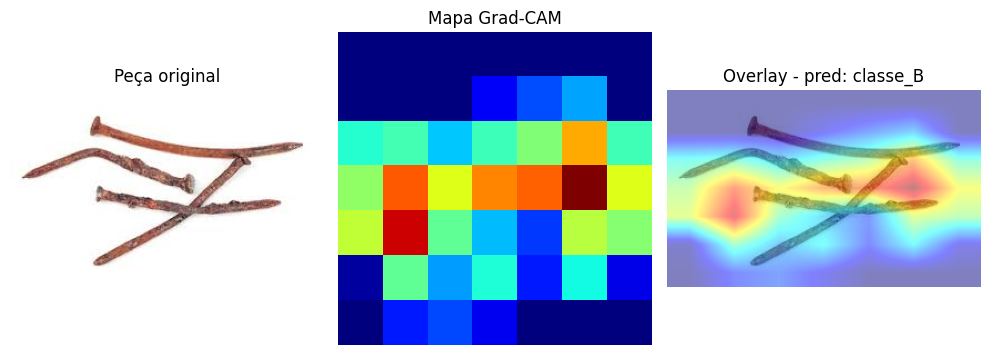

In [16]:
# carrega o melhor modelo treinado
model = get_model(num_classes=num_classes, feature_extract=True).to(device)
model.load_state_dict(torch.load("best_factory_parts_model.pth", map_location=device))
model.eval()

# escolhe a camada convolucional alvo (último bloco da ResNet18)
target_layer = model.layer4[-1].conv2

# === ADIÇÃO PARA CORRIGIR O ERRO ===
# Garante que os parâmetros da camada alvo tenham requires_grad=True
# para que o gradiente possa ser retido em suas ativações.
# Isso não afeta o modelo treinado, pois estamos em modo .eval()
# e não faremos otimização aqui.
for param in target_layer.parameters():
    param.requires_grad = True
# ===================================

gradcam = GradCAM(model, target_layer)

# escolhe uma imagem de validação
test_image_path = "/content/data/val/classe_B/images (1).jpg"  # ajuste o caminho pra uma peça com defeito

orig_pil, input_tensor = load_image_as_tensor(test_image_path)

cam, pred_idx = gradcam(input_tensor)
pred_class_name = class_names[pred_idx]
print("Classe predita:", pred_class_name)

overlay = overlay_cam_on_image(orig_pil, cam, alpha=0.5)

plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.title("Peça original")
plt.imshow(orig_pil)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mapa Grad-CAM")
plt.imshow(cam, cmap="jet")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Overlay - pred: {pred_class_name}")
plt.imshow(overlay)
plt.axis("off")

plt.tight_layout()
plt.show()